<a href="https://colab.research.google.com/github/peeyushsinghal/ERA/blob/main/S11/S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title importing model, mains, utils
!git clone https://github.com/peeyushsinghal/common-pytorch-models.git
import os
os.getcwd()
os.chdir('common-pytorch-models')

Cloning into 'common-pytorch-models'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 156 (delta 3), reused 0 (delta 0), pack-reused 146
Receiving objects: 100% (156/156), 51.08 KiB | 5.11 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [2]:
!pip install torchsummary

In [3]:
from __future__ import print_function
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import os

In [4]:
# import albumentations as A
# import numpy as np
# from albumentations.pytorch.transforms import ToTensorV2

### Dataset and **Transformations**

In [5]:
from utils.transforms import apply_transforms_resnet

In [6]:
# from custom_resnet import *

In [7]:
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
train_transforms, test_transforms = apply_transforms_resnet(mean,std)
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:05<00:00, 28899326.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


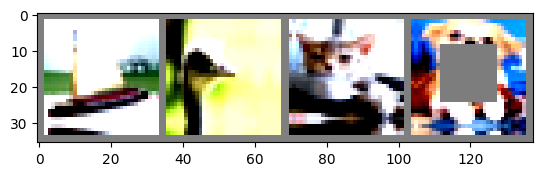

ship  bird  cat   dog  


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [10]:
from torchsummary import summary
from models.resnet import ResNet18
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

### One Cycle LR

In [15]:
import copy
model_oclr = copy.deepcopy(model)
model_oclr = model_oclr.to(device)

In [16]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_oclr.parameters(), lr=0.0001, momentum=0.9)

In [13]:
! pip install torch_lr_finder

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.78E-01


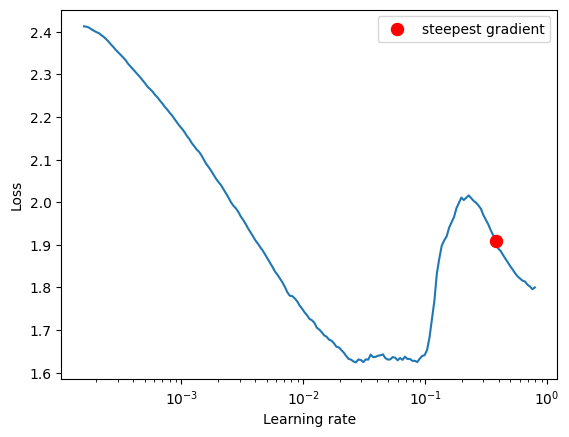

In [17]:
from torch_lr_finder import LRFinder
from tqdm.autonotebook import tqdm

lr_finder = LRFinder(model_oclr, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

### Training

In [18]:
import torch.nn as nn

max_lr = 0.378
EPOCHS = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=float(max_lr),
                                                steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS,
                                                pct_start=(5/EPOCHS),## how much percent of cycle to use for building up
                                                div_factor=10,## initial lr max/div_factor
                                                three_phase=False, ## no annihilation
                                                final_div_factor=50,## min lr max/div_factor
                                                anneal_strategy='linear'
                                                )

In [19]:
model = model.to(device)
from custom_resnet import trainer

train_accuracy, train_losses, test_accuracy, test_losses = trainer(model = model,
                                                                    device = device,
                                                                    trainloader = train_loader,
                                                                    testloader = test_loader,
                                                                    optimizer = optimizer,
                                                                    epochs = EPOCHS,
                                                                    criterion = criterion,
                                                                    scheduler= scheduler)

EPOCH: 1


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.501183032989502 Batch_id=97 Accuracy=37.23: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.0002, Accuracy: 4285/10000 (42.85%)

EPOCH: 2


Loss=1.2402818202972412 Batch_id=97 Accuracy=54.10: 100%|██████████| 98/98 [00:51<00:00,  1.89it/s]



Test set: Average loss: 0.0001, Accuracy: 5718/10000 (57.18%)

EPOCH: 3


Loss=0.8329741358757019 Batch_id=97 Accuracy=63.06: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.0001, Accuracy: 6432/10000 (64.32%)

EPOCH: 4


Loss=0.8300096392631531 Batch_id=97 Accuracy=69.18: 100%|██████████| 98/98 [00:52<00:00,  1.85it/s]



Test set: Average loss: 0.0001, Accuracy: 7148/10000 (71.48%)

EPOCH: 5


Loss=0.7982666492462158 Batch_id=97 Accuracy=74.56: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]



Test set: Average loss: 0.0001, Accuracy: 7236/10000 (72.36%)

EPOCH: 6


Loss=0.6008396744728088 Batch_id=97 Accuracy=77.79: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.0001, Accuracy: 6962/10000 (69.62%)

EPOCH: 7


Loss=0.6067472696304321 Batch_id=97 Accuracy=80.33: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.0001, Accuracy: 7773/10000 (77.73%)

EPOCH: 8


Loss=0.4741043448448181 Batch_id=97 Accuracy=82.81: 100%|██████████| 98/98 [00:51<00:00,  1.89it/s]



Test set: Average loss: 0.0001, Accuracy: 8270/10000 (82.70%)

EPOCH: 9


Loss=0.4617694318294525 Batch_id=97 Accuracy=84.49: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]



Test set: Average loss: 0.0001, Accuracy: 7996/10000 (79.96%)

EPOCH: 10


Loss=0.3667498230934143 Batch_id=97 Accuracy=85.71: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.0001, Accuracy: 8282/10000 (82.82%)

EPOCH: 11


Loss=0.36029067635536194 Batch_id=97 Accuracy=87.22: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.0001, Accuracy: 8617/10000 (86.17%)

EPOCH: 12


Loss=0.33421510457992554 Batch_id=97 Accuracy=88.10: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.0000, Accuracy: 8581/10000 (85.81%)

EPOCH: 13


Loss=0.29512524604797363 Batch_id=97 Accuracy=89.20: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.0000, Accuracy: 8562/10000 (85.62%)

EPOCH: 14


Loss=0.2796902358531952 Batch_id=97 Accuracy=90.17: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.0000, Accuracy: 8756/10000 (87.56%)

EPOCH: 15


Loss=0.18924768269062042 Batch_id=97 Accuracy=91.03: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.0000, Accuracy: 8510/10000 (85.10%)

EPOCH: 16


Loss=0.24975831806659698 Batch_id=97 Accuracy=91.77: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.0000, Accuracy: 8653/10000 (86.53%)

EPOCH: 17


Loss=0.19364789128303528 Batch_id=97 Accuracy=92.56: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.0000, Accuracy: 8879/10000 (88.79%)

EPOCH: 18


Loss=0.14804299175739288 Batch_id=97 Accuracy=93.36: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.0000, Accuracy: 8854/10000 (88.54%)

EPOCH: 19


Loss=0.147579625248909 Batch_id=97 Accuracy=93.86: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.0000, Accuracy: 8924/10000 (89.24%)

EPOCH: 20


Loss=0.16665223240852356 Batch_id=97 Accuracy=94.81: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.0000, Accuracy: 8880/10000 (88.80%)

EPOCH: 21


Loss=0.09477163851261139 Batch_id=97 Accuracy=95.52: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]



Test set: Average loss: 0.0000, Accuracy: 9012/10000 (90.12%)

EPOCH: 22


Loss=0.08618885278701782 Batch_id=97 Accuracy=96.05: 100%|██████████| 98/98 [00:51<00:00,  1.92it/s]



Test set: Average loss: 0.0000, Accuracy: 9103/10000 (91.03%)

EPOCH: 23


Loss=0.10706552118062973 Batch_id=97 Accuracy=96.61: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]



Test set: Average loss: 0.0000, Accuracy: 9125/10000 (91.25%)

EPOCH: 24


Loss=0.1267133504152298 Batch_id=97 Accuracy=97.20: 100%|██████████| 98/98 [00:51<00:00,  1.92it/s]



Test set: Average loss: 0.0000, Accuracy: 9155/10000 (91.55%)



## Assessing training and output

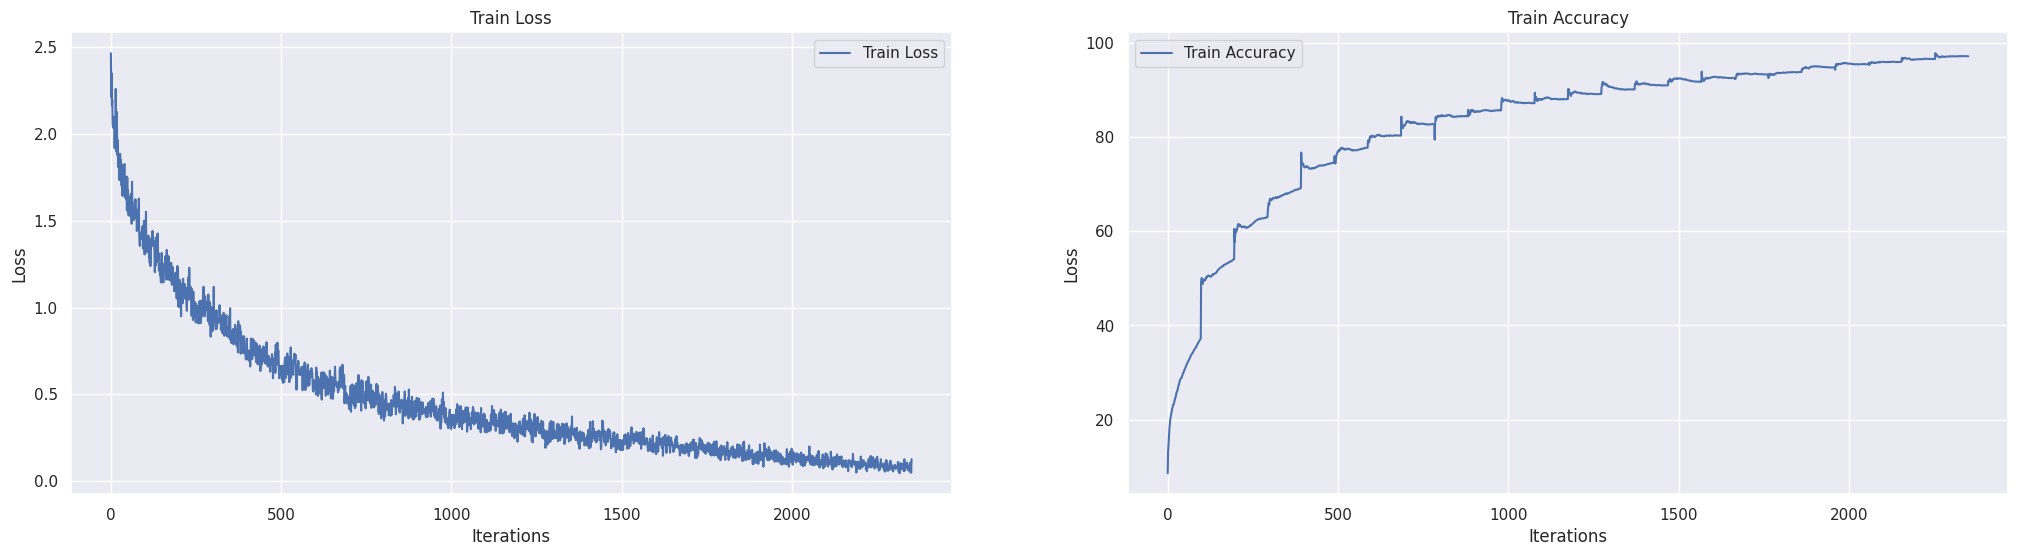

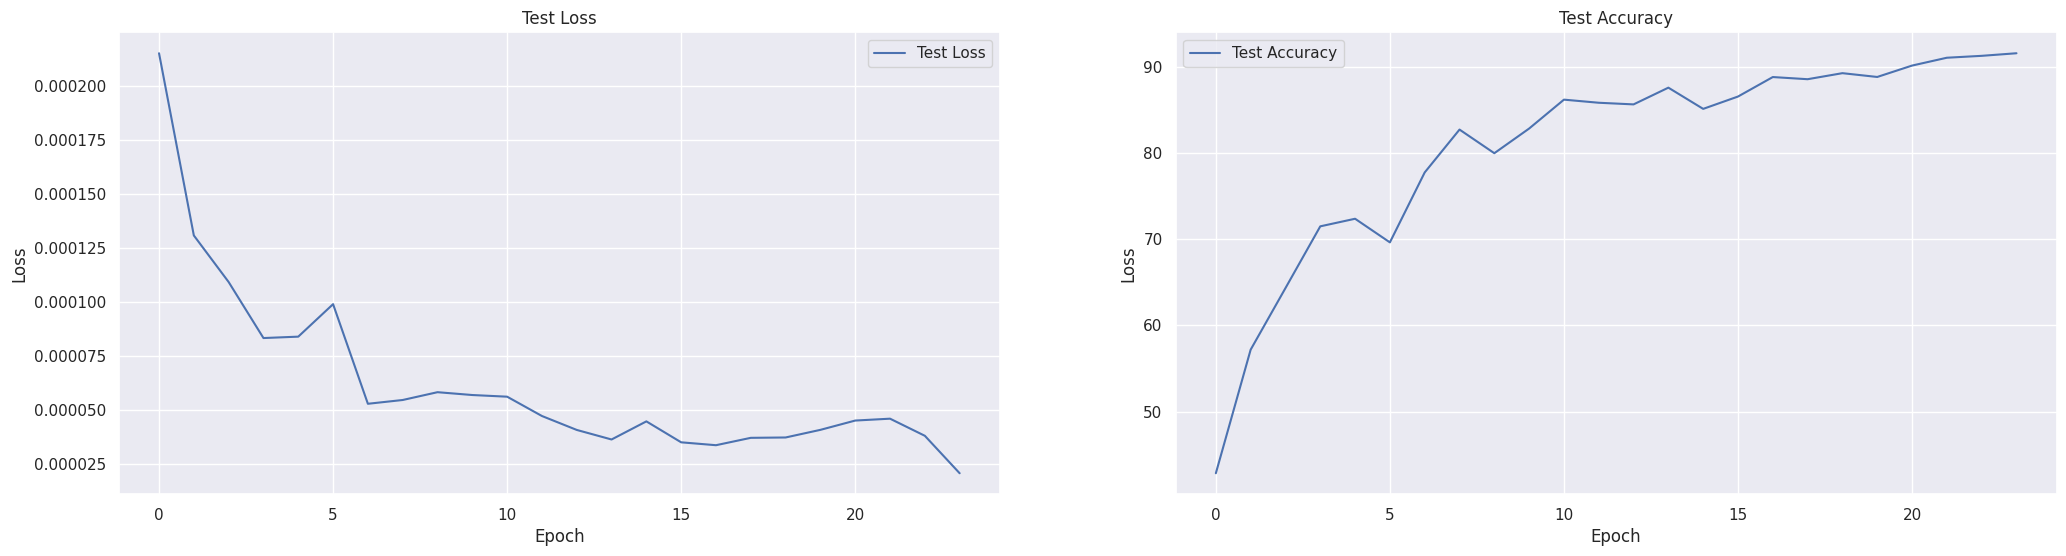

In [21]:
from utils.plot_utils import plot_metrics
plot_metrics(train_accuracy, [x.cpu().detach().numpy() for x in train_losses], test_accuracy, test_losses)

In [22]:
from utils.helper import evaluate_classwise_accuracy
evaluate_classwise_accuracy(model, device, classes, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 88 %
Accuracy of  deer : 100 %
Accuracy of   dog : 90 %
Accuracy of  frog : 83 %
Accuracy of horse : 100 %
Accuracy of  ship : 80 %
Accuracy of truck : 100 %


## Misclasssified Images

Total wrong predictions are 845


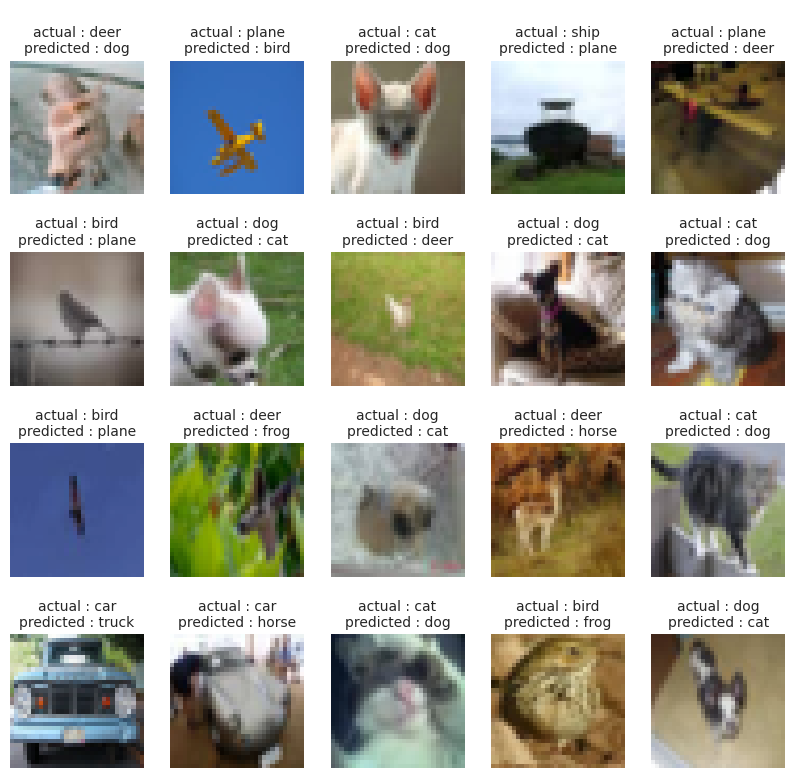

In [23]:
from utils.plot_utils import misclassified_images
images_misclassified = misclassified_images(model, test_loader, device, mean, std , class_names=classes)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Generating Grad-CAM for layer1
Generating Grad-CAM for layer2
Generating Grad-CAM for layer3
Generating Grad-CAM for layer4


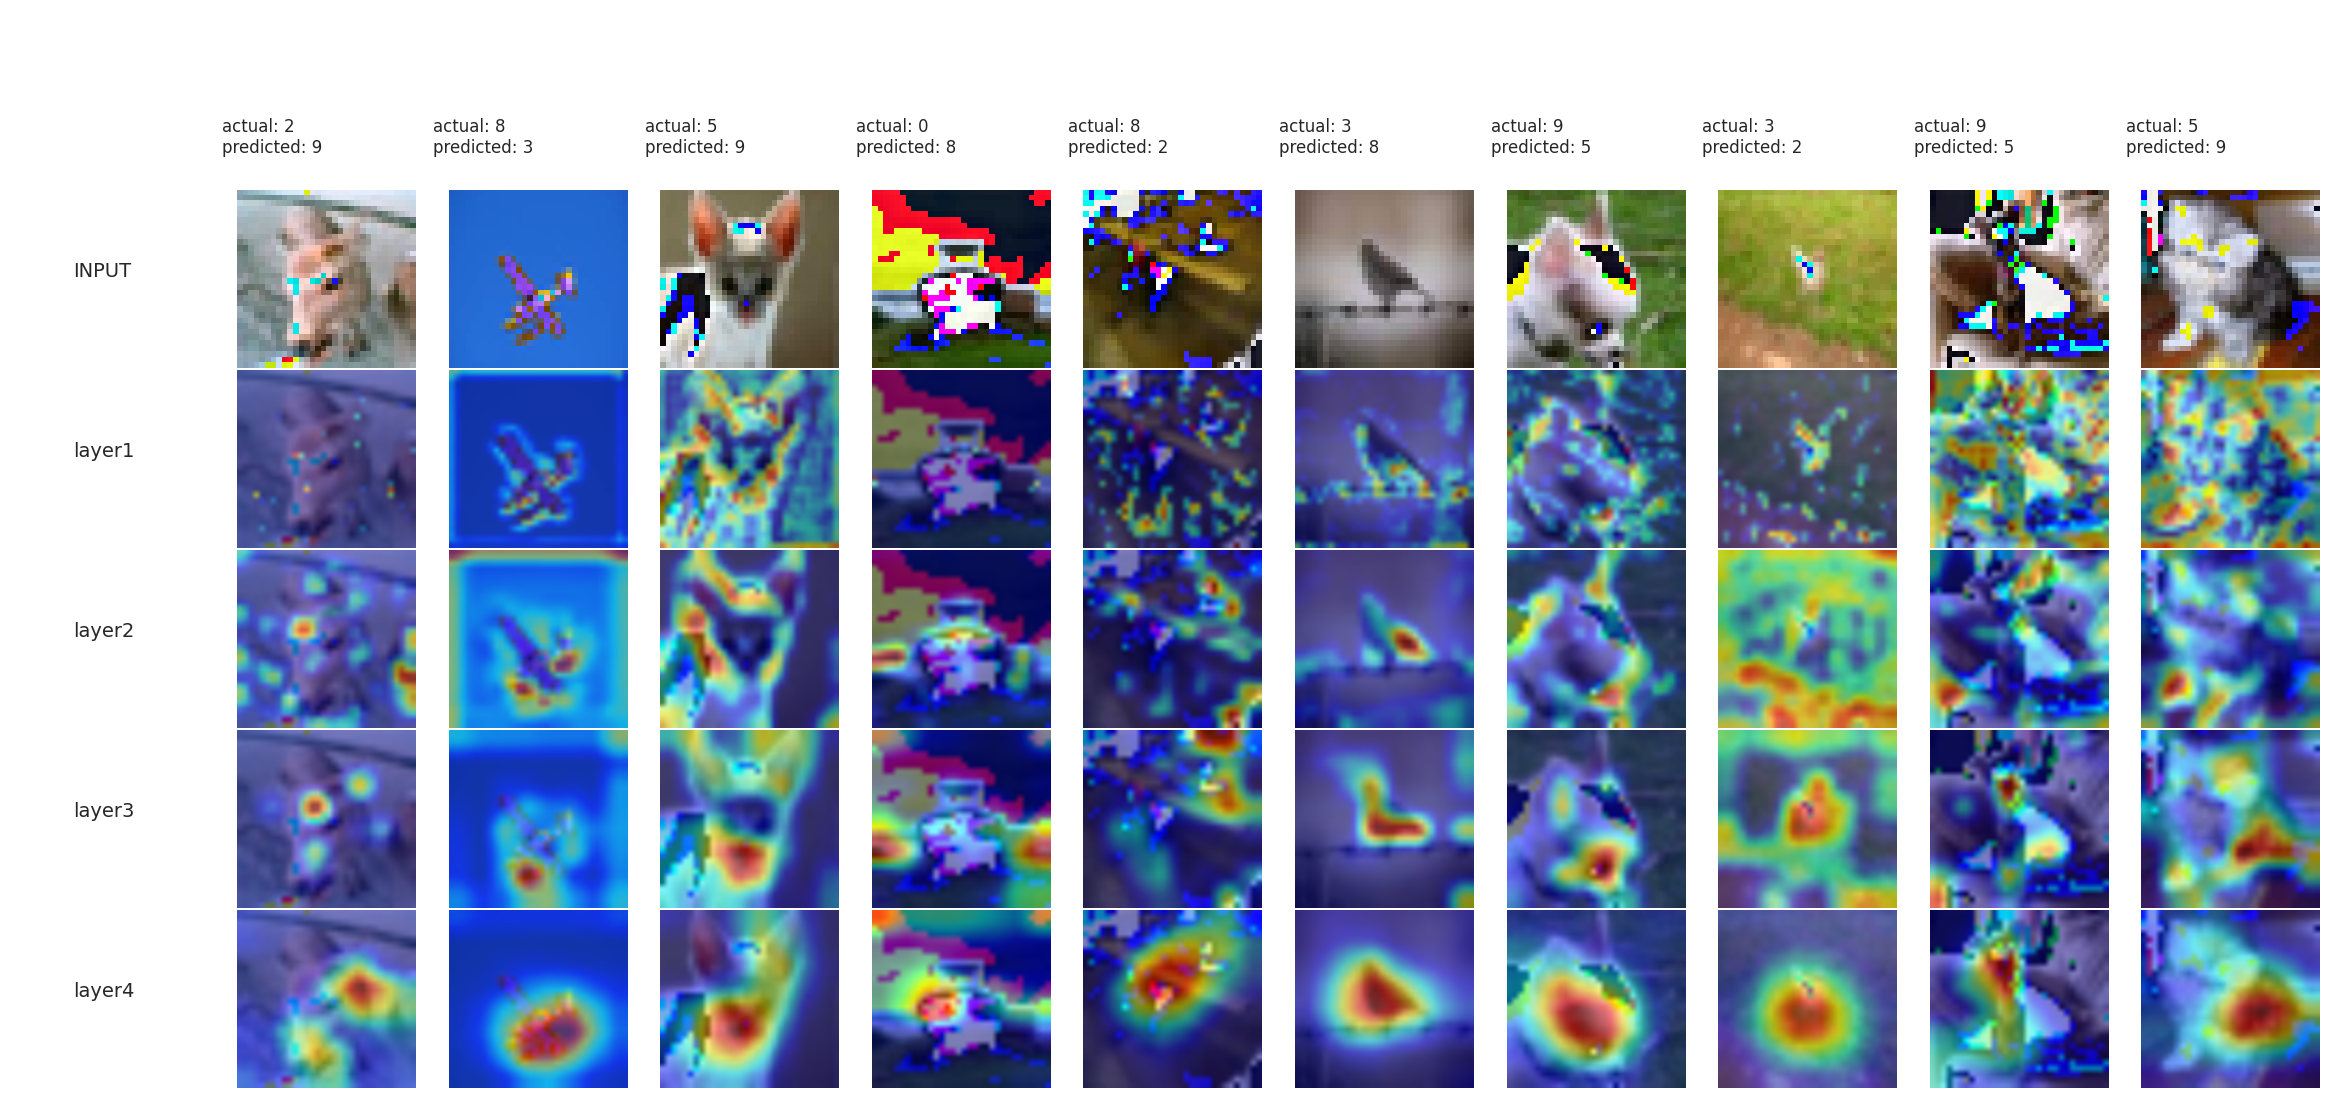

In [24]:
#@title Grad Cam on misclassified images

from utils.grad_cam import generate_gradcam, plot_gradcam

target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = generate_gradcam(images_misclassified[:10], model, target_layers, device)
plot_gradcam(gradcam_output, target_layers, labels, (3, 32, 32), predicted_classes, images_misclassified[:10])